In [ ]:
import cv2
import os
from ultralytics import YOLO
import subprocess
import multiprocessing
from datetime import datetime, timedelta
import mysql.connector
from mysql.connector import Error
import torch
from db_sql import predict_count, resize_image
import tensorflow as tf
from timmML_025.models.factory import create_model
import torchvision.transforms as transforms
from PIL import Image
import signal
import sys
import time
import random
import string
from color_detection import format_output, crop_and_classify
import joblib

# import cProfile


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("/home/devendra/ai-camera/backend/stream/best.pt")
model.to(device)
connection = mysql.connector.connect(
    host="localhost", user="root", password="", database="logs"
)


# Signal handler function
def signal_handler(sig, frame):
    print("Termination signal received. Releasing resources...")
    if "video_writer" in globals() and video_writer is not None:
        video_writer.release()
    sys.exit(0)


# Register the signal handler
signal.signal(signal.SIGINT, signal_handler)
signal.signal(signal.SIGTERM, signal_handler)


def get_creation_time(file_path):
    # Get the file creation time
    if os.name == "nt":  # Windows
        creation_time = os.path.getctime(file_path)
    else:
        stat = os.stat(file_path)
        # try:
        #     creation_time = stat.st_birthtime
        # except AttributeError:
        #     # For Linux, if birth time is not available, fall back to the last metadata change time
        creation_time = stat.st_mtime

    return datetime.fromtimestamp(creation_time)


def get_video_frame_time(video_path, frame_number):
    # Get the start time from the file creation time
    start_time = get_creation_time(video_path)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # Get the frame rate of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        print("Error: Could not retrieve frame rate.")
        return None

    # Calculate the elapsed time since the start of the video
    elapsed_time_seconds = frame_number / fps
    elapsed_time = timedelta(seconds=elapsed_time_seconds)

    # Calculate the actual time of the frame
    actual_time = start_time + elapsed_time

    # Release the video capture object
    cap.release()
    return actual_time



def insert_into_table(
    camera_id,
    camera_ip,
    timestamp,
    box_coords,
    detection_class,
    track_id,
    class_confidence,
    metadata,
):
    try:
        connection = mysql.connector.connect(
            host="localhost", user="root", password="", database="logs"
        )
        if connection.is_connected():
            cursor = connection.cursor()
            insert_query = f"INSERT INTO detection_logs (camera_id, camera_ip, timestamp, box_coords, detection_class, track_id, class_confidence, metadata) VALUES ('{camera_id}' ,'{camera_ip}', '{timestamp}', '{box_coords}', '{detection_class}', '{track_id}', '{class_confidence}', '{metadata}');"
            cursor.execute(insert_query)
            connection.commit()
    except Error as e:
        print(f"Error: {e}")
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()


def generate_custom_string(cam_ip, track_id):
    # Replace dots in the camera IP with underscores
    cam_ip = cam_ip.replace(".", "_")

    # Get the current timestamp
    current_timestamp = int(time.time())

    # Generate a random string of 4 characters and 4 digits mixed
    random_mix = "".join(random.choices(string.ascii_letters + string.digits, k=8))

    # Combine all parts into the final string
    custom_string = f"{random_mix}_{track_id}_{current_timestamp}_{cam_ip}"

    return custom_string


# Function to detect and display objects in video
def detect_and_display(video_path, output_path, cam_id, cam_ip):
    # Set up the crowd count model
    global video_writer

    crowd_count_model = create_model("efficientnet_lite0")
    PATH_model = "/home/devendra/ai-camera/backend/stream/student_025.pt"
    MEAN_STD = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    crowd_count_model.load_state_dict(torch.load(PATH_model, map_location=device))
    crowd_count_model.to(device)
    crowd_count_model.eval()
    img_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(MEAN_STD[0], MEAN_STD[1])]
    )

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    width, height = 640, 480
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    crowd_count = 0
    crowd_confidence = 0.0

    custom_track_ids = {}

    while cap.isOpened():
        ret, ori_frame = cap.read()
        if not ret:
            break
        frame_count += 1
        vehicle_count = 0
        if frame_count == 60:
            break
        frame = cv2.resize(ori_frame, (width, height))

        results = model.track(frame, persist=True, device=device)

        for result in results:
            boxes = result.boxes.xyxy.cpu().numpy()
            scores = result.boxes.conf.cpu().numpy()
            classes = result.boxes.cls.cpu().numpy()
            # set1 = set(classes)
            # print(set1)
            # set2 = set([0,1,2,3,4,5,6])
            # intersection  = set1.intersection(set2)
            # vehicle_count = len(intersection)
            track_ids = (
                result.boxes.id.int().cpu().tolist()
                if result.boxes.id is not None
                else []
            )

            for box, score, cls, track_id in zip(boxes, scores, classes, track_ids):
                x1, y1, x2, y2 = map(int, box)
                label = model.names[int(cls)]
                class_confidence = score
                if track_id not in custom_track_ids:
                    custom_track_ids[track_id] = generate_custom_string(
                        cam_ip, track_id
                    )

                # custom unique tracking id
                custom_id = custom_track_ids[track_id]

                # vehicle count
                if label in [
                    "auto",
                    "motorbike",
                    "bike-rider",
                    "car",
                    "suv",
                    "hatchback",
                    "sedan",
                    "scooty-rider",
                    "scooty",
                    "bus",
                    "truck",
                    "tractor",
                    "loader",
                ]:
                    vehicle_count += 1

                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
                cv2.putText(
                    frame,
                    f"{label}",
                    (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.2,
                    (0, 255, 0),
                    1,
                )
                cropped_img = frame[y1:y2, x1:x2]

                # Insert into the database
                at = get_video_frame_time(video_path, frame_count)
                classifier = joblib.load(
                    "/home/devendra/ai-camera/backend/stream/pixel_classifier.joblib"
                )
                label_encoder = joblib.load(
                    "/home/devendra/ai-camera/backend/stream/label_encoder.joblib"
                )

                output = crop_and_classify(
                    cropped_img, label, classifier, label_encoder
                )
                metadata = format_output(output)
                metadata = """{
                    "upper": {"black": 0.30, "red": 0.23, "charcoal": 0.20},
                    "lower": {"black": 0.35, "charcoal": 0.31, "red": 0.26},
                }"""
                insert_into_table(
                    camera_id=cam_id,
                    camera_ip=cam_ip,
                    # timestamp=at,
                    timestamp="2024-07-07 12:00:00",
                    box_coords=[x1, y1, x2, y2],
                    detection_class=label,
                    track_id=custom_id,
                    class_confidence=class_confidence,
                    metadata=metadata,
                )

        # Crowd count processing
        if frame_count % 5 == 0:
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(rgb_frame)
            img = resize_image(img)
            crowd_count, crowd_confidence = predict_count(img, crowd_count_model)

            # Insert crowd count into the database
            # at = get_video_frame_time(video_path, frame_count)
            crowd_insert_into_table(
                camera_id=cam_id,
                camera_ip=cam_ip,
                # timestamp=at,
                timestamp="2024-07-07 12:00:00",
                crowd_count=crowd_count,
                crowd_count_confidence_score=crowd_confidence,
            )
            vehicle_count_insert_into_table(
                camera_id=cam_id,
                camera_ip=cam_ip,
                timestamp="2024-07-07 12:00:00",
                # timestamp=at,
                vehicle_count=vehicle_count,
            )

        # # Overlay FPS and crowd count on the frame
        fps_text = f"FPS: {fps}"
        crowd_count_text = f"Crowd Count: {crowd_count}"
        cv2.putText(
            frame, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1
        )
        cv2.putText(
            frame,
            crowd_count_text,
            (10, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1,
        )
        vehicle_count_text = f"Vehicle Count : {vehicle_count}"
        cv2.putText(
            frame,
            str(vehicle_count_text),
            (450, 30),
            cv2.FONT_HERSHEY_DUPLEX,
            0.5,
            (0, 255, 0),
            1,
        )

        video_writer.write(frame)
        # cv2.imshow("test", frame)
    cap.release()
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()


def crowd_insert_into_table(
    camera_id, camera_ip, timestamp, crowd_count, crowd_count_confidence_score
):
    try:
        connection = mysql.connector.connect(
            host="localhost", user="root", password="", database="logs"
        )
        if connection.is_connected():
            cursor = connection.cursor()
            insert_query = f"INSERT INTO crowd_count (camera_id, camera_ip, timestamp, crowd_count, crowd_count_confidence_score) VALUES ('{camera_id}', '{camera_ip}',' {timestamp}',' {crowd_count}', '{crowd_count_confidence_score}')"
            cursor.execute(insert_query)
            connection.commit()
    except Error as e:
        print(f"Error: {e}")
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()


def vehicle_count_insert_into_table(camera_id, camera_ip, timestamp, vehicle_count):
    try:
        connection = mysql.connector.connect(
            host="localhost", user="root", password="", database="logs"
        )
        if connection.is_connected():
            cursor = connection.cursor()
            insert_query = f"INSERT INTO vehicle_count_logs (camera_id, camera_ip, timestamp, vehicle_count) VALUES ('{camera_id}', '{camera_ip}',' {timestamp}',' {vehicle_count}')"
            cursor.execute(insert_query)
            connection.commit()
    except Error as e:
        print(f"Error: {e}")
    finally:
        if connection.is_connected():
            cursor.close()
            connection.close()


def run_multiprocesses():
    # multiprocessing.set_start_method("spawn",force=True)
    cam_id1 = "6"
    cam_id2 = "2"
    cam_id3 = "3"
    cam_id4 = "4"

    cam_ip1 = "171.31.4.79"
    cam_ip2 = "171.31.4.36"
    cam_ip3 = "171.31.4.47"
    cam_ip4 = "171.31.4.57"
    detect_and_display(
        "/home/devendra/data/171.31.4.79.MKV",
        "/home/devendra/data/output/171.31.4.79_output.mp4",
        cam_id1,
        cam_ip1,
    )
    # p1 = multiprocessing.Process(
    #     target=detect_and_display,
    #     args=(
    #          "/home/devendra/data/171.31.4.79.MKV",
    #         "/home/devendra/data/output/171.31.4.79_output.mp4",
    #         cam_id1,
    #         cam_ip1,
    #     ),
    # )
    # p2 = multiprocessing.Process(
    #     target=detect_and_display,
    #     args=(
    #         "/home/devendra/data/171.31.4.36.MKV",
    #         "/home/devendra/data/output/171.31.4.36_output.mp4",
    #         cam_id2,
    #         cam_ip2,
    #     ),
    # )
    # p3 = multiprocessing.Process(
    #     target=detect_and_display,
    #     args=(
    #         "/home/devendra/data/171.31.4.47.MKV",
    #         "/home/devendra/data/output/171.31.4.47_output.mp4",
    #         cam_id3,
    #         cam_ip3,
    #     ),
    # )
    # p4 = multiprocessing.Process(
    #     target=detect_and_display,
    #     args=(
    #         "/home/devendra/data/171.31.4.57.MKV",
    #         "/home/devendra/data/output/171.31.4.57_output.mp4",
    #         cam_id4,
    #         cam_ip4,
    #     ),
    # )

    # p1.start()
    # p2.start()
    # p3.start()
    # p4.start()

    # p1.join()
    # p2.join()
    # p3.join()
    # p4.join()


if __name__ == "__main__":
    import cProfile, pstats
    import io
    from pstats import SortKey

    profiler = cProfile.Profile()
    profiler.enable()
    # cProfile.run('run_multiprocesses()')
    t1 = time.time()
    cam_id1 = "6"
    cam_ip1 = "171.31.4.79"
    detect_and_display(
        "/home/devendra/data/171.31.4.79.MKV",
        "/home/devendra/data/output/171.31.4.79_output.mp4",
        cam_id1,
        cam_ip1,
    )
    t2 = time.time()
    print(t1-t2)
    profiler.disable()
    s = io.StringIO()
    sortby = SortKey.CUMULATIVE
    stats = pstats.Stats(profiler, stream=s).sort_stats(sortby)
    stats.print_stats()
    stats.strip_dirs()
    stats.print_stats()
    # Save the profiling results to a file
    profiler.dump_stats(
        "/home/devendra/ai-camera/backend/stream/profiling_results.prof"
    )

    # Use snakeviz to visualize the results
    import os

    os.system("snakeviz /home/devendra/ai-camera/backend/stream/profiling_results.prof")

In [ ]:
# from module import crowd_count_on_frame,insert_into_table,crowd_insert_into_table,generate_custom_string,do_threading
from module import do_threading
import time
import cv2

In [ ]:

t1 = time.time()
# generate_custom_string("23.45.67.89","ABGC25563")
# insert_into_table()
# crowd_insert_into_table()
# print(crowd_count_on_frame(cv2.imread("/home/annone/ai-camera/backend/stream_test/4.png")))
do_threading()
t2 = time.time()
print(t2-t1)


In [ ]:
import cv2
import numpy as np

# Read coordinates from the file
with open('/home/annone/ai-camera/vid1_frame_87.txt', 'r') as file:
    data = file.read().strip().split()
    coords = list(map(float, data[1:]))

# Image dimensions
img_width, img_height = 1920,1080

# Function to denormalize coordinates
def denormalize_coords(coords, img_width, img_height):
    denormalized = []
    for i in range(0, len(coords), 2):
        x = coords[i] * img_width
        y = coords[i + 1] * img_height
        denormalized.append((x, y))
    return denormalized

# Denormalize coordinates
denormalized_coords = denormalize_coords(coords, img_width, img_height)

# Load the image (replace 'image_path' with the actual image path)
image_path = '/home/annone/ai-camera/vid1_frame_87.jpg'
image = cv2.imread(image_path)

# Create a mask
mask = np.zeros((img_height, img_width), dtype=np.uint8)

# Fill the polygon in the mask
pts = np.array(denormalized_coords, np.int32)
pts = pts.reshape((-1, 1, 2))
cv2.fillPoly(mask, [pts], 255)

# Create a new image with an alpha channel (4 channels)
polygon_image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
polygon_image[:, :, 3] = mask

# Crop to the bounding box of the polygon
x, y, w, h = cv2.boundingRect(pts)
cropped_polygon_image = polygon_image[y:y+h, x:x+w]

# Save the cropped polygon image (replace 'cropped_polygon_image_path' with the desired path)
cropped_polygon_image_path = 'cropped_polygon_image.png'
cv2.imwrite(cropped_polygon_image_path, cropped_polygon_image)

# Display the cropped polygon image
cv2.imshow('Cropped Polygon Image', cropped_polygon_image)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [ ]:
from color_detection import format_output, crop_and_classify
import joblib
import cv2
from PIL import Image
import time
t1 = time.time()
classifier = joblib.load(
                    "/home/annone/ai-camera/backend/stream_test/pixel_classifier.joblib"
)
label_encoder = joblib.load(
                    "/home/annone/ai-camera/backend/stream_test/label_encoder.joblib")
output = crop_and_classify(
                    "/home/annone/ai-camera/backend/stream/cropped_polygon_image.png", "bike-rider", classifier, label_encoder
)
print(output)
t2 = time.time()
print(t2-t1)


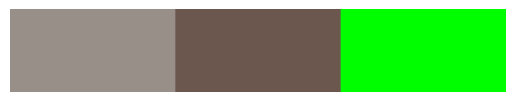

Top 3 dominant colors (RGB): [[152 143 136]
 [108  87  79]
 [  0 254   0]]


In [7]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def preprocess_image(image):
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    return image

def find_dominant_colors(image_path, k=3):
    image = cv2.imread(image_path)
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(image)
    colors = kmeans.cluster_centers_
    counts = np.bincount(kmeans.labels_)

    # Order the colors by the number of pixels assigned
    sorted_indices = np.argsort(counts)[::-1]
    dominant_colors = colors[sorted_indices]
    return dominant_colors.astype(int)

def plot_colors(colors):
    # Create an image to display the colors
    color_image = np.zeros((50, 300, 3), dtype="uint8")

    start = 0
    for i, color in enumerate(colors):
        end = start + (300 // len(colors))
        cv2.rectangle(color_image, (start, 0), (end, 50), color.tolist(), -1)
        start = end

    # Display the color image
    plt.figure()
    plt.axis("off")
    plt.imshow(color_image)
    plt.show()

def main(image_path):
    # image = load_image(image_path)
    # processed_image = preprocess_image(image_path)
    dominant_colors = find_dominant_colors(image_path, k=3)
    plot_colors(dominant_colors)
    print("Top 3 dominant colors (RGB):", dominant_colors)

if __name__ == "__main__":
    image_path = "/home/annone/ai/data/eee.png"  # Replace with your image path
    main(image_path)


In [ ]:
import redis

r = redis.Redis(host='localhost', port=6379, db=0)

# r.set('count', 89)
count = r.get('test')
print(count)


In [ ]:
import redis

# Connect to Redis
r = redis.Redis(host='localhost', port=6379, db=0)

# Function to get all keys and their values
def get_all_data():
    # Use SCAN to get all keys (more efficient than KEYS for large datasets)
    cursor = '0'
    all_keys = []

    while cursor != 0:
        cursor, keys = r.scan(cursor=cursor)
        all_keys.extend(keys)

    # Dictionary to hold all key-value pairs
    all_data = {}

    # Get the value for each key
    for key in all_keys:
        key_type = r.type(key).decode('utf-8')
        
        if key_type == 'string':
            value = r.get(key)
            try:
                all_data[key.decode('utf-8')] = value.decode('utf-8')
            except UnicodeDecodeError:
                all_data[key.decode('utf-8')] = value
        elif key_type == 'hash':
            hash_data = r.hgetall(key)
            decoded_hash_data = {k.decode('utf-8'): v.decode('utf-8') for k, v in hash_data.items()}
            all_data[key.decode('utf-8')] = decoded_hash_data
        elif key_type == 'list':
            list_data = r.lrange(key, 0, -1)
            decoded_list_data = [item.decode('utf-8') for item in list_data]
            all_data[key.decode('utf-8')] = decoded_list_data
        elif key_type == 'set':
            set_data = r.smembers(key)
            decoded_set_data = {item.decode('utf-8') for item in set_data}
            all_data[key.decode('utf-8')] = decoded_set_data
        elif key_type == 'zset':
            zset_data = r.zrange(key, 0, -1, withscores=True)
            decoded_zset_data = [(item[0].decode('utf-8'), item[1]) for item in zset_data]
            all_data[key.decode('utf-8')] = decoded_zset_data
        else:
            all_data[key.decode('utf-8')] = f'Unsupported data type: {key_type}'

    return all_data

# Example usage
if __name__ == "__main__":
    data = get_all_data()
    for key, value in data.items():
        print(f"Key: {key}, Value: {value}")


In [1]:
from  PIL import Image
import PIL.Image
import redis
import PIL
import os
import cv2
# from module import k_mean_color_detection
import numpy as np
import random
# from module import  process_raw_d_logs, process_d_logs, process_raw_cc_logs, process_cc_logs

# Connect to the Redis server
r = redis.Redis(host='localhost', port=6379, db=0)

def clear_redis_database():
    r.flushdb()
    print("Redis database cleared.")

# Function to store string data with key namespacing
def store_string_with_namespace(serial_number, constant_string, value):
    full_key = f"{serial_number}:{constant_string}"
    r.set(full_key, value)
    print(f"Stored {full_key} -> {value}")

# Function to retrieve all data matching the constant part of the key
def retrieve_keys(constant_string):
    matching_keys = r.keys(f"*:{constant_string}")
    results = {}
    for key in matching_keys:
        value = r.get(key)
        if value:
            decoded_key = key.decode()
            decoded_value = value.decode()
            # np_arr = np.frombuffer(value, np.uint8)
            # Decode the numpy array back to an image
            # retrieved_image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
            # results[decoded_key] = retrieved_image
            results[decoded_key] = decoded_value
            # r.delete(decoded_key)
            # print(results)
            # r.delete(key)  # Delete the key after retrieving the value
            # print(f"Retrieved and deleted {decoded_key} -> {decoded_value}")
    return results

def retrieve_image(constant_string):
    matching_keys = r.keys(f"*:{constant_string}")
    results = {}
    for key in matching_keys:
        value = r.get(key)
        if value:
            decoded_key = key.decode()
            # decoded_value = value.decode()
            np_arr = np.frombuffer(value, np.uint8)
            # Decode the numpy array back to an image
            image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
            # image = image.reshape((image.shape[0] * image.shape[1], 3))
            # image = image.reshape((-1, image.shape[2]))
            # cv2.imwrite(f"/home/annone/ai/backend/stream/d_temp/{decoded_key}.png", image)
            results[decoded_key] = image
            # results[decoded_key] = decoded_value
            # r.delete(decoded_key)
            # print(results)
            # r.delete(key)  # Delete the key after retrieving the value
            # print(f"Retrieved and deleted {decoded_key} -> {decoded_value}")
    return results

# def process_raw_d_logs(constant_string):
#     while True:
#         matching_keys = r.keys(f"*:{constant_string}")
#         # print(matching_keys)
#         for key in matching_keys:
#             value = r.get(key)
#             decode_key = key.decode()
#             decode_value = value.decode().split("|")
#             track_id = decode_value[5]
#             image_path = decode_value[7]
#             try:
#                 image = cv2.imread(f"/home/annone/ai-camera/backend/stream/temp/{image_path}")
#                 image = image.reshape((image.shape[0] * image.shape[1], 3))
#                 aa = k_mean_color_detection(image)
#                 decode_value[7]  = aa
#                 r.set(f"{track_id}_{random.randint(0,9999)}:d_log","|".join(decode_value))
#                 os.remove(f"/home/annone/ai-camera/backend/stream/temp/{image_path}")
#                 r.delete(decode_key)
#             except:
#                 # print("excepted")
#                 continue
            # show_rgb_colors(aa,image)
            # print(decode_value)

# def process_d_logs(constant_string):
#     conn = Database.get_connection()
#     cursor = conn.cursor()
#     batch = []
#     while True:
#         matching_keys = r.keys(f"*:{constant_string}")
#         for key in matching_keys:
#             value = r.get(key)
#             decode_key = key.decode()
#             decode_value = value.decode().split("|")
#             batch.append(tuple(decode_value))
#         if len(batch) > 0:
#             query = 'INSERT INTO "DetectionLog" ("cameraId", "camera_ip", "timestamp", "boxCoords", "detectionClass", "trackId", "classConfidence", "metadata") VALUES %s;'
#             execute_values(cursor, query, batch)
#             conn.commit()
#             cursor.close()
#             conn.close()
#             batch = []

In [15]:
retrieve_image("image")

{}

In [16]:
retrieve_keys("d_log")
# clear_redis_database()

{}

In [ ]:
process_raw_d_logs(auto_loop=False)

In [7]:
retrieve_keys("raw_cc_log")

{}

In [ ]:
process_d_logs("d_log")

In [2]:
clear_redis_database()

Redis database cleared.


In [ ]:
import psycopg2
from psycopg2.extras import execute_values
from db import Database
from module import  process_raw_d_logs, process_d_logs, process_raw_cc_logs, process_cc_logs

In [ ]:
process_raw_d_logs(auto_loop=False)

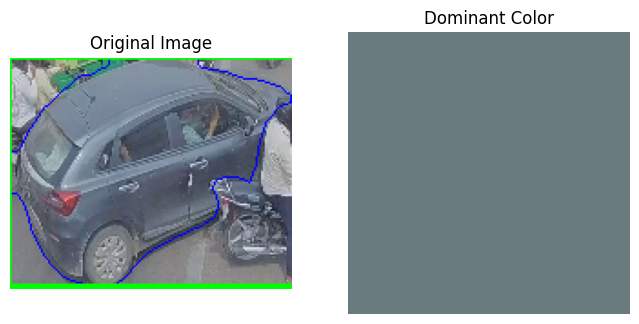

Dominant Color (RGB): [106 123 127]


In [2]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Load the image
image = cv2.imread('/home/annone/ai/data/eee.png')

# Step 2: Convert the image from BGR to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 3: Convert the image to grayscale
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Step 4: Apply a binary threshold to create a mask (segmented area)
_, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Step 5: Apply the mask to the image
masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

# Step 6: Reshape the masked image to a 2D array of pixels
pixels = masked_image.reshape(-1, 3)

# Step 7: Filter out the black pixels (background)
pixels = pixels[pixels.sum(axis=1) > 0]

# Step 8: Perform KMeans clustering to find the dominant color
kmeans = KMeans(n_clusters=1)
kmeans.fit(pixels)
dominant_color = kmeans.cluster_centers_[0]

# Step 9: Display the original image and the dominant color
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dominant Color')
plt.imshow([[dominant_color/255]])
plt.axis('off')

plt.show()

print(f"Dominant Color (RGB): {dominant_color.astype(int)}")
